In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import numpy as np
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import seaborn as sns
import scipy
from scipy.stats import lognorm, truncpareto, wasserstein_distance
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
!mkdir -p /content
!unzip pch_train.zip -d /content/train
!find /content/train/pchdata -type d -empty -delete

!unzip pch_val.zip -d /content/val
!find /content/val -type d -empty -delete
!find /content/val/pchdata -mindepth 1 -maxdepth 1 -type d \
  -exec sh -c 'count=$(find "$1" -maxdepth 1 -name "GT*.json" | wc -l); [ "$count" -lt 10 ] && rm -rf "$1"' _ {} \;

In [2]:
class LogSet(Dataset):
    def __init__(self, root):
        self.root = root
        self.files = sorted([
            f for f in os.listdir(root)
            if os.path.isfile(os.path.join(root, f))
            and f.endswith(".json")
            and "metadata" not in f
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(os.path.join(self.root, self.files[idx]), "r") as f:
            sim_data = json.load(f)
            pch = np.array(sim_data['Data']['pch_bins'], dtype=np.float32)
            amps = np.array(sim_data['Data']['raw_particle_amps'], dtype=np.float32)
            pch /= pch.sum()
            
            log_edges = np.logspace(np.log10(50), np.log10(8000), 51)
            log_bins, _ = np.histogram(amps.astype(float), bins=log_edges)
            
        return torch.tensor(pch, dtype=torch.float32), torch.tensor(log_bins, dtype=torch.float32)
        
class ValSet(Dataset):
    def __init__(self, root):
        self.root = root
        self.folders = sorted(os.listdir(self.root))
    
    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        pchs = []
        log_tdists = []
        lin_tdists = []

        sigma_s1 = sigma_s2 = sigma_s3 = alpha = None
        AmpS1 = AmpS2 = AmpS3 = None
        Frac1 = Frac2 = Frac3 = 0.0

        for i in range(10):
            with open(os.path.join(self.root, self.folders[idx], f"GT{i:02}.json"), "r") as f:
                sim_data = json.load(f)
            log_edges = np.logspace(np.log10(50), np.log10(8000), 51)
            lin_edges = np.linspace(0, 8000, 101)
            pch = np.array(sim_data["Data"]["pch_bins"], dtype=np.float32)
            pch /= pch.sum()
            pchs.append(torch.tensor(pch, dtype=torch.float32))

            amps = np.array(sim_data["Data"]["raw_particle_amps"], dtype=np.float32)
            print(amps)
            lin_bins, _ = np.histogram(amps, bins=lin_edges)
            log_bins, _ = np.histogram(amps, bins=log_edges)

            lin_tdists.append(torch.tensor(lin_bins, dtype=torch.float32))
            log_tdists.append(torch.tensor(log_bins, dtype=torch.float32))

            sim_in = sim_data["SimulationInputs"]
            amps   = sim_data["Amplitudes"]
            fracs  = sim_data["ActualFractions"]

            sigma_s1 = sim_in["sigma_bS1"]
            sigma_s2 = sim_in["sigma_bS2"]
            sigma_s3 = sim_in["sigma_bS3"]
            
            alpha = sim_in['alpha']

            AmpS1 = amps['AmpS1']
            AmpS2 = amps['AmpS2']
            AmpS3 = amps['AmpS3']

            Frac1 = fracs["Frac1"]
            Frac2 = fracs["Frac2"]
            Frac3 = fracs["Frac3"]

            conc = sim_data['ActualConcentrations']['Total']
            num_species = sim_in['num_species']

        return (
            pchs, lin_tdists, log_tdists,
            (sigma_s1, sigma_s2, sigma_s3, alpha),
            (AmpS1, AmpS2, AmpS3),
            (Frac1, Frac2, Frac3),
            conc, num_species
        )

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        if in_channels != out_channels:
            self.projection = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.projection = None
        self.gelu = nn.GELU()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.projection:
            identity = self.projection(identity)
        out += identity
        out = self.gelu(out)
        return out

class BASLOG(nn.Module):
    def __init__(self, input_length=24, output_dim=50, init_beta=0.5):
        super().__init__()
        self.resblock1 = ResidualBlock(1, 32)
        self.dropout1 = nn.Dropout(0.15)
        self.resblock2 = ResidualBlock(32, 64)
        self.dropout2 = nn.Dropout(0.15)
        # self.resblock3 = ResidualBlock(64, 128)
        # self.dropout3 = nn.Dropout(0.25)
        # self.resblock4 = ResidualBlock(128, 128)
        # self.dropout4 = nn.Dropout(0.25)

        # self.head_conv = nn.Conv1d(64, 1, kernel_size=1)
        # self.pool = nn.AdaptiveAvgPool1d(output_dim)

        self.log_beta = nn.Parameter(torch.log(torch.tensor(init_beta, dtype=torch.float32)))
        

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * input_length, 32 * input_length)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32 * input_length, output_dim)
        self.dropout = nn.Dropout(0.25)
        # self.softplus = nn.Softplus(beta=0.5)
        # self.softmax = nn.Softmax(dim = 1)
    def beta(self):
        return torch.exp(self.log_beta).clamp_min(1e-4)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.dropout1(self.resblock1(x))
        x = self.dropout2(self.resblock2(x))

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        
        beta = self.beta()
        x = torch.nn.functional.softplus(x * beta)/beta
        return x


In [19]:
lr = 2e-5
BATCH_SIZE = 32
NUM_EPOCHS = 250
model = BASLOG(output_dim=50).to(device)

beta_param = []
other_params = []
for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    if name == "log_beta":
        beta_param.append(p)
    else:
        other_params.append(p)
optimizer = torch.optim.AdamW([
    {'params': other_params, 'lr':2e-5, 'weight_decay':1e-3},
    {'params': beta_param, 'lr':7e-4, 'weight_decay':0.0}
])
criterion = nn.PoissonNLLLoss(log_input=False)

dataset = LogSet(r"/content/train/pchdata")

train_ratio = 0.8
val_ratio = 0.2

val_size = int(val_ratio * len(dataset))
train_size = len(dataset) - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 30

In [ ]:
train_losses = []
val_losses = []
betas = []

for epoch in tqdm(range(NUM_EPOCHS)):
    total_loss = 0.0
    val_loss = 0.0
    model.train()
    for i, (pch, tdist) in enumerate(train_loader):
        pch, tdist = pch.to(device), tdist.to(device)
        pred_dist = model(pch)
        loss = criterion(pred_dist, tdist)
        
        if i == 200:
            true_pch = pch[0].cpu().numpy()
            pred_dist = pred_dist[0].cpu().detach().numpy()
            true_dist = tdist[0].cpu().numpy()
            wass = wasserstein_distance(true_dist, pred_dist)
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].plot(true_pch, marker='o', label='True PCH')
            axes[0].set_title("Photon Counting Histogram")
            axes[0].set_xlabel("Bin")
            axes[0].set_ylabel("Intensity Count")
            axes[0].legend()
            axes[0].grid(True)

            axes[1].plot(true_dist, marker='o', label=f'True Brightness Dist')
            axes[1].plot(pred_dist, marker='x', linestyle='--', label='Predicted Brightness Dist')
            axes[1].set_title(wass)
            axes[1].set_xlabel("Bin")
            axes[1].set_ylabel("Particle Count")
            axes[1].legend()
            axes[1].grid(True)

            plt.tight_layout()
            plt.show()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        for pch, tdist in val_loader:
            pch, tdist = pch.to(device), tdist.to(device)
            pred_dist = model(pch)
            s_p = pred_dist.sum(axis=1)
            s_t = tdist.sum(axis=1)
            loss = criterion(pred_dist, tdist)
            
            val_loss += loss.item()

    current_val_loss = val_loss / len(val_loader)
    scheduler.step(current_val_loss)
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping")
            break
    
    print(f"Epoch {epoch} | Loss: {total_loss / len(train_loader)} | Val: {val_loss / len(val_loader)} | Beta: {model.beta()}")
    
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    betas.append(model.beta())

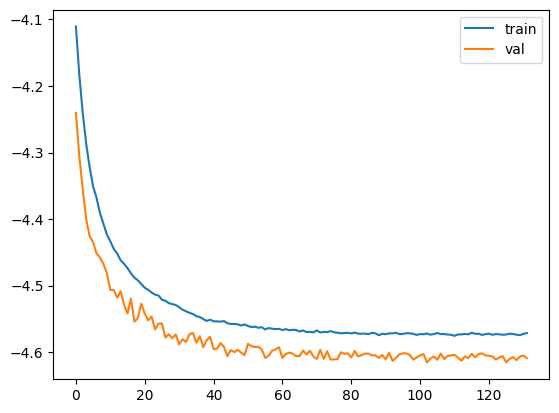

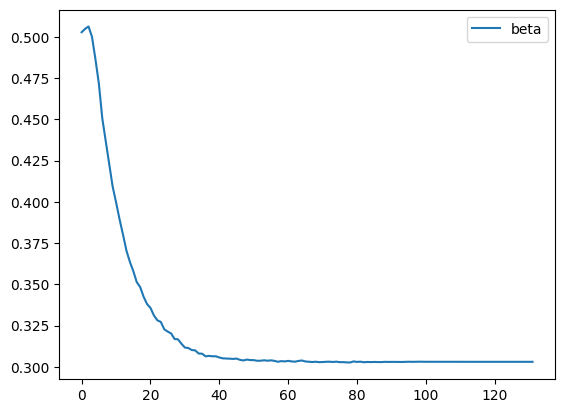

In [26]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

plt.clf()
betas = betas#[beta.cpu().detach().numpy() for beta in betas]
plt.plot(betas, label='beta')
plt.legend()
plt.show()

In [27]:
torch.save({
    "model_state_dict":model.state_dict(),
    "optim_state_dict":optimizer.state_dict()},
           f"bas_log_{datetime.now().strftime('%m-%d_%H-%M')}.pth")

In [68]:
def lognormal_mixture_bin_probs(edges, components):
    edges = np.asarray(edges)
    p_bins = np.zeros(len(edges) - 1, dtype=float)

    total_w = sum(w for *_, w in components)
    if total_w <= 0 or len(components) == 0:
        return p_bins

    for Amp, sigma, w in components:
        sigma = float(sigma)
        mu = np.log(Amp) - 0.5 * sigma**2
        scale = np.exp(mu)
        rv = lognorm(s=sigma, scale=scale)

        cdf_hi = rv.cdf(edges[1:])
        cdf_lo = rv.cdf(edges[:-1])
        p_bins += (w / total_w) * (cdf_hi - cdf_lo)

    s = p_bins.sum()
    if s > 0:
        p_bins /= s
    return p_bins


def powerlaw_brightness_bin_probs(edges, Amp, alpha, setDt=500e-6):
    edges = np.asarray(edges, dtype=float)
    p_bins = np.zeros(len(edges) - 1, dtype=float)

    if Amp is None or alpha is None or Amp <= 0:
        return p_bins

    Rp = Amp / setDt
    xmin = 1e5 / Rp

    if alpha > 0:
        xmax = 1.6e7 / Rp
    else:
        xmax = 1.0e7 / Rp

    y_edges = edges / Amp 

    ymin = xmin
    ymax = xmax

    y0 = np.clip(y_edges[:-1], ymin, ymax)
    y1 = np.clip(y_edges[1:],  ymin, ymax)

    if np.isclose(alpha, 1.0):
        denom = np.log(ymax / ymin)
        if denom <= 0:
            return p_bins
        F0 = np.log(y0 / ymin) / denom
        F1 = np.log(y1 / ymin) / denom
    else:
        a = 1.0 - alpha
        denom = (ymax**a - ymin**a)
        if denom == 0:
            return p_bins
        F0 = (y0**a - ymin**a) / denom
        F1 = (y1**a - ymin**a) / denom

    p_bins = F1 - F0

    p_bins[(y_edges[1:] <= ymin) | (y_edges[:-1] >= ymax)] = 0.0

    s = p_bins.sum()
    if s > 0:
        p_bins /= s

    return p_bins


In [7]:
checkpoint = torch.load("/content/baslog_12-09_07-43.pth", map_location=device)
model = BASLOG().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer = torch.optim.AdamW(
#     [
#         {"params": [p for n,p in model.named_parameters() if n != "log_beta"], "lr": base_lr, "weight_decay": 1e-3},
#         {"params": [model.log_beta], "lr": beta_lr, "weight_decay": 0.0},
#     ]
# )

# checkpoint = torch.load(path, map_location=device)
# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer.load_state_dict(checkpoint["optim_state_dict"])
# model.train()

<All keys matched successfully>

In [32]:
model.eval()
fig_set = ValSet(r"/content/train/pchdata")
fig_loader = DataLoader(
    fig_set, batch_size=1, shuffle=False, collate_fn=lambda batch: batch[0]
)
os.makedirs('figures', exist_ok=True)

KSstats_u = np.empty(len(fig_set))
KSstats_d = np.empty(len(fig_set))
Ps_u = np.empty(len(fig_set))
Ps_d = np.empty(len(fig_set))
wass_u = np.empty(len(fig_set))

xmin, xmax = 50.0, 8000.0
nbins = 50
distedges = np.logspace(np.log10(xmin), np.log10(xmax), nbins + 1)  # (51,)
bin_left = distedges[:-1]                                           # (50,)
bin_right = distedges[1:]                                           # (50,)
bin_centers = np.sqrt(bin_left * bin_right)                         # geometric centers (50,)
bin_widths = bin_right - bin_left                                   # variable widths (50,)

for j, (pchs, tdists, log_tdists, sigmas, amps, fracs, conc, num_species) in tqdm(enumerate(fig_loader)):
    ref = log_tdists[0]
    assert all(torch.equal(ref, t) for t in log_tdists[1:])
    true_np = ref.detach().squeeze().cpu().numpy().astype(float)
    true_np /= true_np.sum()

    with torch.no_grad():
        preds = []
        for pch in pchs:
            pch = pch.unsqueeze(0).to(device)  # (1, nbins)
            out = model(pch)              # should be (1,100)
            out = out.squeeze(0)          # now (100,)
            pred = out.detach().cpu().numpy().astype(np.float64)
            if j < 3:
                print("---- sample", j, "----")
                print("pred raw:  min", pred.min(), "max", pred.max(),
                      "sum", pred.sum(), "argmax", pred.argmax(),
                      "pred[0:5]", pred[:5])

            preds.append(pred)
        pred_dists = np.stack(preds, axis=0)  # (10, 100)

    # normalize each predicted distribution to sum to 1
    row_sums = pred_dists.sum(axis=1, keepdims=True)
    pred_dists_norm = pred_dists / (row_sums)
    
    if j < 3:
        print("row_sums (first 3):", row_sums[:3].ravel())
        print("pred_norm first run: min", pred_dists_norm[0].min(),
              "max", pred_dists_norm[0].max(),
              "sum", pred_dists_norm[0].sum(),
              "argmax", pred_dists_norm[0].argmax(),
              "first5", pred_dists_norm[0][:5])


    pred_np = pred_dists_norm.mean(axis=0)
    if j < 3:
        print("pred_np: sum", pred_np.sum(), "max", pred_np.max(),
              "argmax", pred_np.argmax(), "first5", pred_np[:5])
    error_bars = 2 * pred_dists_norm.std(axis=0)

    

    # ---------- Continuous "population" distribution ----------
    clean = lambda x: None if x == 0 else x
    
    sigma_s1, sigma_s2, sigma_s3, alpha = [clean(v) for v in sigmas]
    AmpS1, AmpS2, AmpS3 = [clean(v) for v in amps]
    Frac1, Frac2, Frac3 = fracs

    AmpS1, AmpS2, AmpS3 = [clean(v) for v in (AmpS1, AmpS2, AmpS3)]
    sigma_s1, sigma_s2, sigma_s3 = [clean(v) for v in (sigma_s1, sigma_s2, sigma_s3)]
    alpha = clean(alpha)
    
    if alpha is None:
        components = []
        if AmpS1 is not None and sigma_s1 is not None and Frac1 > 0:
            components.append((AmpS1, sigma_s1, Frac1))
        if AmpS2 is not None and sigma_s2 is not None and Frac2 > 0:
            components.append((AmpS2, sigma_s2, Frac2))
        if AmpS3 is not None and sigma_s3 is not None and Frac3 > 0:
            components.append((AmpS3, sigma_s3, Frac3))
        p_bins = lognormal_mixture_bin_probs(distedges, components)
    else:
        p_bins = powerlaw_brightness_bin_probs(distedges, AmpS1, alpha)

    y_continuous = p_bins
    x_for_line = bin_centers

    # KS test
    KS_d, p_d = scipy.stats.ks_2samp(true_np, pred_np)
    KSstats_d[j] = KS_d
    Ps_d[j] = p_d
    KS_u, p_u = scipy.stats.ks_2samp(y_continuous, pred_np)
    KSstats_u[j] = KS_u
    Ps_u[j] = p_u

    wass = wasserstein_distance(true_np, pred_np)
    wass_u[j] = wass

    residuals = true_np - pred_np

    fig, axes = plt.subplots(3, 1, figsize=(12, 12),
        sharex=True,
        gridspec_kw={"height_ratios": [1, 1, 1], "hspace": 0.15},
    )

    p1 = lognormal_mixture_bin_probs(distedges, [(AmpS1, sigma_s1, 1.0)]) if (AmpS1 and sigma_s1) else None
    p2 = lognormal_mixture_bin_probs(distedges, [(AmpS2, sigma_s2, 1.0)]) if (AmpS2 and sigma_s2) else None
    p3 = lognormal_mixture_bin_probs(distedges, [(AmpS3, sigma_s3, 1.0)]) if (AmpS3 and sigma_s3) else None

    abs_max = max(np.max(y_continuous), np.max(true_np), np.max(pred_np), np.max(np.abs(residuals)))

    
    # 1) Underlying (true) distribution
    ax0 = axes[0]
    ax0.bar(
        bin_left,
        true_np,
        width=bin_widths,
        align='edge',
        label="Sampled Distribution",
        color="red",
        edgecolor="black",
        linewidth=0.5,
    )
    ax0.plot(
        x_for_line,
        y_continuous,
        label="Population Distribution",
        linewidth=3,
    )
    if num_species > 1:
        if p1 is not None:
            ax0.plot(bin_centers, Frac1 * p1, linestyle="--", color = 'orange', linewidth=1.5, label="Species 1 Contribution")
        if p2 is not None:
            ax0.plot(bin_centers, Frac2 * p2, linestyle="--", color = 'green',linewidth=1.5, label="Species 2 Contribution")
        if p3 is not None:
            ax0.plot(bin_centers, Frac3 * p3, linestyle="--", color = 'yellow', linewidth=1.5, label="Species 3 Contribution")

    ax0.set_ylabel("Probability")
    ax0.set_title("Underlying Fluorescence Distribution")
    ax0.grid(True, linestyle="--", alpha=0.5, axis="y")
    ax0.set_ylim((0, abs_max + 0.1))
    ax0.legend()


    # 2) Predicted distribution
    ax1 = axes[1]
    ax1.bar(
        bin_left,
        pred_np,
        width=bin_widths,
        align='edge',
        label="Predicted",
        color="deepskyblue",
        edgecolor="black",
        linewidth=0.5,
    )
    ax1.set_ylabel("Relative Concentration")
    ax1.set_title("Predicted Fluorescence Distribution")
    ax1.grid(True, linestyle="--", alpha=0.5, axis="y")
    ax1.set_ylim((0, abs_max + 0.1))


    # 3) Residuals
    ax2 = axes[2]
    ax2.bar(
        bin_left,
        residuals,
        width=bin_widths,
        align='edge',
        color="gray",
        edgecolor="black",
        linewidth=0.5,
    )
    ax2.errorbar(
        x=bin_centers,
        y=np.zeros_like(residuals),
        yerr=error_bars,
        fmt="none",
        ecolor="red",
        elinewidth=1,
        capsize=3,
        zorder=10,
    )
    ax2.axhline(0, color="black", linewidth=1, linestyle="--")
    ax2.set_ylabel("Residual")
    ax2.set_xlabel("Fluorescence Intensity")
    ax2.set_title("Residuals & Error Bars")
    ax2.grid(True, linestyle="--", alpha=0.5, axis="y")

    for ax in axes:
        ax.set_xscale("log")
        ax.set_xlim(xmin, xmax)

    xticks = np.array([50, 100, 200, 500, 1000, 2000, 5000, 8000], dtype=float)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([str(int(t)) for t in xticks], rotation=0)

    
    fig.suptitle(
        f"Concentrations Across Fluorescence Intervals  |  wasserstein: {wass:.3f}",
        fontsize=14,
        y=0.94,
    )
    # plt.savefig(f"figures/{j}.png", dpi=600, bbox_inches='tight')
    plt.show()
    # print("amps: " + str(amps))
    # print("fracs: " + str(fracs))
    # print("sigmas: " + str(sigmas))
    # print("conc: " + str(conc))

    if j == 100:
        break

0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/train/pchdata/.ipynb_checkpoints/GT00.json'

In [ ]:
!unzip /workspace/pchtest.zip -d /content/test
!find /content/test/pchdata -type d -empty -delete

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# ---------- Dataset ----------
class LogSet(Dataset):
    def __init__(self, root, xmin=50.0, xmax=8000.0, nbins=50):
        self.root = root
        self.files = sorted([
            f for f in os.listdir(root)
            if os.path.isfile(os.path.join(root, f)) and f.endswith(".json")
        ])
        self.xmin = float(xmin)
        self.xmax = float(xmax)
        self.nbins = int(nbins)
        self.log_edges = np.logspace(np.log10(self.xmin), np.log10(self.xmax), self.nbins + 1)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        import json
        with open(os.path.join(self.root, self.files[idx]), "r") as f:
            sim_data = json.load(f)

        pch = np.array(sim_data["Data"]["pch_bins"], dtype=np.float32)
        amps = np.array(sim_data["Data"]["raw_particle_amps"], dtype=np.float32)

        pch_sum = float(pch.sum())
        if pch_sum > 0:
            pch = pch / pch_sum

        log_bins, _ = np.histogram(amps.astype(float), bins=self.log_edges)
        return torch.tensor(pch, dtype=torch.float32), torch.tensor(log_bins, dtype=torch.float32)


# ---------- Plot / Eval ----------
model.eval()

root = r"/content/test/pchdata"   # use the consistent train/val split data
fig_set = LogSet(root, xmin=50.0, xmax=8000.0, nbins=50)
fig_loader = DataLoader(fig_set, batch_size=1, shuffle=False)

os.makedirs("figures", exist_ok=True)

xmin, xmax = 50.0, 8000.0
nbins = 50
distedges = np.logspace(np.log10(xmin), np.log10(xmax), nbins + 1)
bin_left = distedges[:-1]
bin_right = distedges[1:]
bin_centers = np.sqrt(bin_left * bin_right)   # geometric mean centers (good for log axis)
bin_widths = bin_right - bin_left

EPS = 1e-12

for j, (pch, tdist) in enumerate(fig_loader):
    # pch: (1, input_len), tdist: (1, 50)
    pch = pch.to(device).float()
    tdist = tdist.squeeze(0).cpu().numpy().astype(np.float64)

    # normalize true to probability mass per bin (sums to 1)
    true_np = tdist / (tdist.sum() + EPS)

    with torch.no_grad():
        out = model(pch)  # expected shape (1, 50)
        if isinstance(out, (tuple, list)):
            out = out[0]
        if isinstance(out, dict):
            out = out["pred"]  # change if needed

        out = out.squeeze(0)  # (50,)
        pred = out.detach().cpu().numpy().astype(np.float64)

    # hard guard: catch mismatched model head early
    if pred.shape[0] != nbins:
        raise ValueError(f"Model output has {pred.shape[0]} bins, expected {nbins}. "
                         f"Fix output_dim or rebin.")

    # normalize prediction to probability mass per bin
    pred_np = pred / (pred.sum() + EPS)

    # Residuals
    residuals = true_np - pred_np

    # Proper Wasserstein distance between distributions over bin centers
    wass = wasserstein_distance(bin_centers, bin_centers, u_weights=true_np, v_weights=pred_np)

    # KS-like stat (no p-value): max CDF deviation
    cdf_true = np.cumsum(true_np)
    cdf_pred = np.cumsum(pred_np)
    ks_stat = np.max(np.abs(cdf_true - cdf_pred))

    # Error bars (optional): Poisson-ish in prob space using predicted counts
    # Only makes sense if pred ~ expected counts (as with PoissonNLL training).
    pred_total = pred.sum() + EPS
    sigma_prob = np.sqrt(np.maximum(pred, 0.0)) / pred_total
    error_bars = 2.0 * sigma_prob

    abs_max = max(true_np.max(), pred_np.max(), np.abs(residuals).max())

    fig, axes = plt.subplots(
        3, 1, figsize=(12, 12),
        sharex=True,
        gridspec_kw={"height_ratios": [1, 1, 1], "hspace": 0.15},
    )

    # 1) True (log-binned) distribution
    ax0 = axes[0]
    ax0.bar(
        bin_left, true_np, width=bin_widths, align="edge",
        label="True (normalized)", color="red",
        edgecolor="black", linewidth=0.5,
    )
    ax0.set_ylabel("Probability")
    ax0.set_title("True Fluorescence Distribution")
    ax0.grid(True, linestyle="--", alpha=0.5, axis="y")
    ax0.set_ylim((0, abs_max + 0.05))
    ax0.legend()

    # 2) Predicted (log-binned) distribution
    ax1 = axes[1]
    ax1.bar(
        bin_left, pred_np, width=bin_widths, align="edge",
        label="Predicted (normalized)", color="deepskyblue",
        edgecolor="black", linewidth=0.5,
    )
    ax1.set_ylabel("Probability")
    ax1.set_title("Predicted Fluorescence Distribution")
    ax1.grid(True, linestyle="--", alpha=0.5, axis="y")
    ax1.set_ylim((0, abs_max + 0.05))
    ax1.legend()

    # 3) Residuals + error bars
    ax2 = axes[2]
    ax2.bar(
        bin_left, residuals, width=bin_widths, align="edge",
        color="gray", edgecolor="black", linewidth=0.5,
    )
    ax2.errorbar(
        x=bin_centers,
        y=np.zeros_like(residuals),
        yerr=error_bars,
        fmt="none",
        ecolor="red",
        elinewidth=1,
        capsize=3,
        zorder=10,
    )
    ax2.axhline(0, color="black", linewidth=1, linestyle="--")
    ax2.set_ylabel("Residual")
    ax2.set_xlabel("Fluorescence Intensity")
    ax2.set_title("Residuals & Error Bars")
    ax2.grid(True, linestyle="--", alpha=0.5, axis="y")
    ax2.set_ylim((-(abs_max + 0.05), abs_max + 0.05))

    # Log x-axis formatting
    for ax in axes:
        ax.set_xscale("log")
        ax.set_xlim(xmin, xmax)

    xticks = np.array([50, 100, 200, 500, 1000, 2000, 5000, 8000], dtype=float)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([str(int(t)) for t in xticks])

    fig.suptitle(
        f"Sample {j} | Wasserstein={wass:.3f} | KS_stat={ks_stat:.3f}",
        fontsize=14,
        y=0.94,
    )

    # plt.savefig(f"figures/{j}.png", dpi=300, bbox_inches="tight")
    plt.show()

    if j == 100:
        break

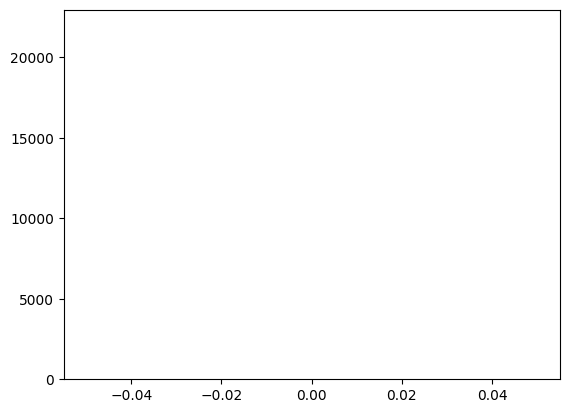

In [37]:
plt.hist(KSstats_u, bins=50)
plt.show()

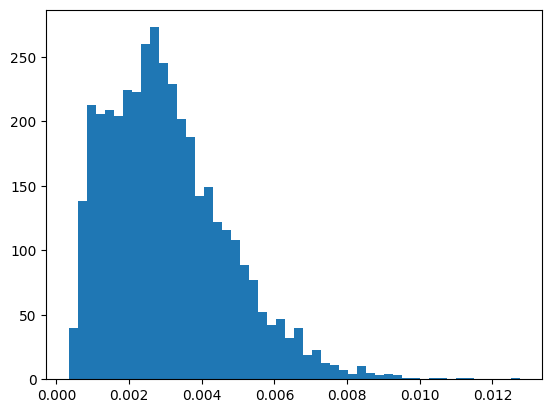

In [38]:
plt.hist(wass_u, bins=50)
plt.show()

In [31]:
wass_u

array([0.00211902, 0.002208  , 0.0014926 , ..., 0.00315622, 0.00351351,
       0.00610171], shape=(3979,))

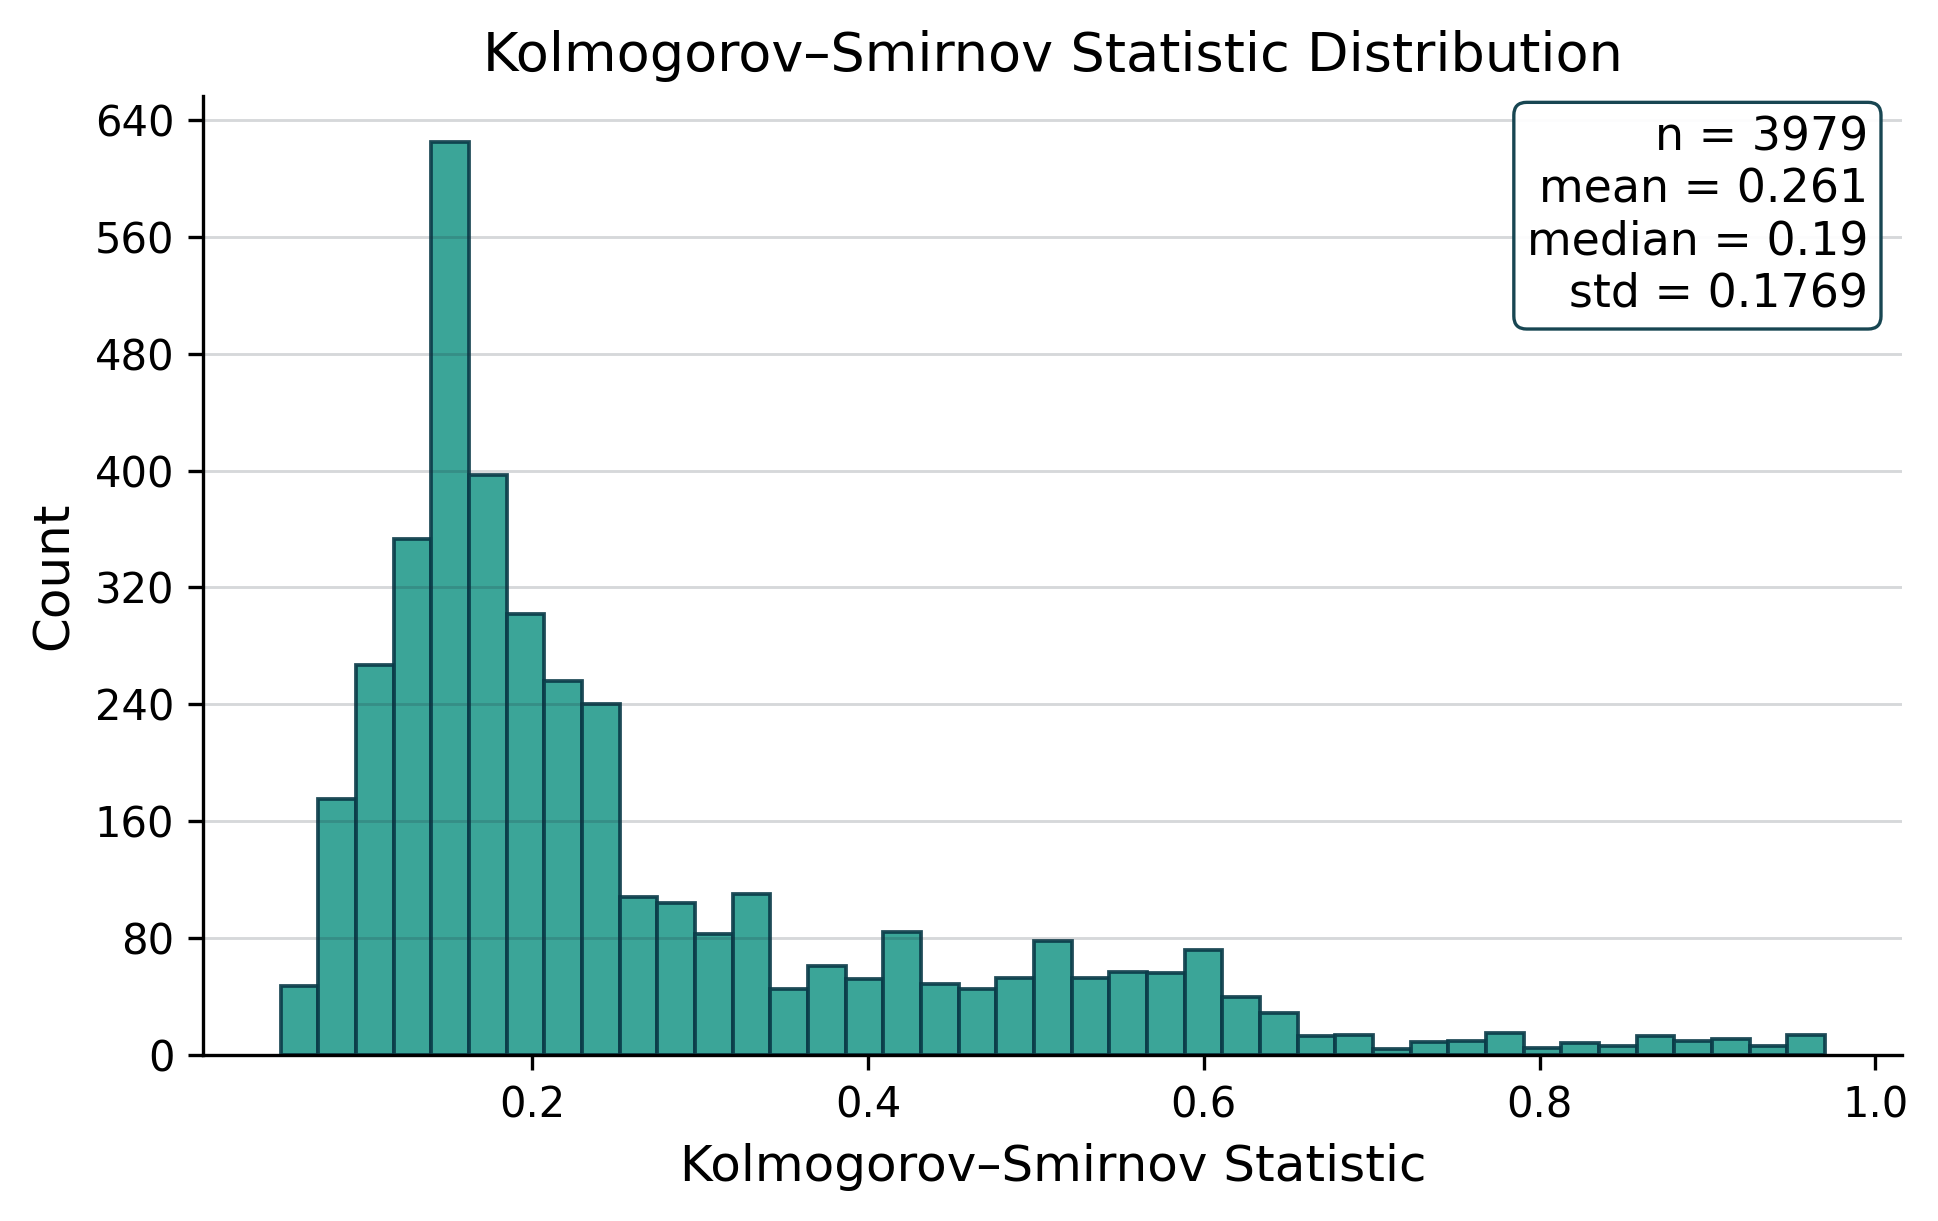

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# --- data cleanup ---
x = np.asarray(KSstats_u).ravel()
x = x[np.isfinite(x)]
if x.size == 0:
    raise ValueError("KSstats_u has no finite values to plot.")

# --- robust binning: Freedman–Diaconis ---
n = x.size
q25, q75 = np.percentile(x, [25, 75])
iqr = q75 - q25
data_range = x.max() - x.min()
if iqr > 0 and data_range > 0:
    bin_width = 2 * iqr * (n ** (-1/3))
    bins = int(np.ceil(data_range / bin_width)) if bin_width > 0 else 30
    bins = int(np.clip(bins, 10, 200))
else:
    bins = 30

# --- publication-ish defaults + vector text embedding ---
plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# --- custom (non-default) palette ---
face = "#2A9D8F"   # teal
edge = "#0B3C49"   # deep blue-green
gridc = "#1F2937"  # charcoal

fig, ax = plt.subplots(figsize=(6.6, 4.2))

counts, bin_edges, patches = ax.hist(
    x,
    bins=bins,
    density=False,               # counts, not density
    color=face,
    edgecolor=edge,
    linewidth=0.9,
    alpha=0.92,
)

# Labels with full test name
ax.set_title("Kolmogorov–Smirnov Statistic Distribution")
ax.set_xlabel("Kolmogorov–Smirnov Statistic")
ax.set_ylabel("Count")

# Cleaner frame + professional grid
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid(True, axis="y", linewidth=0.7, alpha=0.18, color=gridc)
ax.grid(False, axis="x")

# Summary box
summary = (
    f"n = {n}\n"
    f"mean = {x.mean():.4g}\n"
    f"median = {np.median(x):.4g}\n"
    f"std = {x.std(ddof=1):.4g}"
)
ax.text(
    0.98, 0.98, summary,
    transform=ax.transAxes,
    ha="right", va="top",
    bbox=dict(boxstyle="round,pad=0.28", facecolor="white", edgecolor=edge, linewidth=0.8, alpha=0.95),
)

fig.tight_layout()

# Export (PDF for publication, PNG for quick sharing)
fig.savefig("kolmogorov_smirnov_statistic_histogram.pdf", bbox_inches="tight")
fig.savefig("kolmogorov_smirnov_statistic_histogram.png", bbox_inches="tight")
plt.show()


In [134]:
val_mc_set = ValSetLog(r"/content/val/pchdata")
val_mc_loader = DataLoader(val_mc_set, batch_size=1, shuffle=False)
model.eval()
model.to(device)

red_chi2s = []
chi2s = []
ps = []

for _beta in tqdm(np.linspace(0.1, 3.0, 20)):
    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm1d(out_channels)
            self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm1d(out_channels)
            if in_channels != out_channels:
                self.projection = nn.Conv1d(in_channels, out_channels, kernel_size=1)
            else:
                self.projection = None
            self.gelu = nn.GELU()
    
        def forward(self, x):
            identity = x
            out = self.conv1(x)
            out = self.bn1(out)
            out = self.gelu(out)
            out = self.conv2(out)
            out = self.bn2(out)
            if self.projection:
                identity = self.projection(identity)
            out += identity
            out = self.gelu(out)
            return out
    
    class BASCNN(nn.Module):
        def __init__(self, input_length=50, output_dim=100):
            super().__init__()
            self.resblock1 = ResidualBlock(1, 32)
            self.dropout1 = nn.Dropout(0.15)
            self.resblock2 = ResidualBlock(32, 64)
            self.dropout2 = nn.Dropout(0.15)
            # self.resblock3 = ResidualBlock(64, 128)
            # self.dropout3 = nn.Dropout(0.25)
            # self.resblock4 = ResidualBlock(128, 128)
            # self.dropout4 = nn.Dropout(0.25)
    
            # self.head_conv = nn.Conv1d(64, 1, kernel_size=1)
            # self.pool = nn.AdaptiveAvgPool1d(output_dim)
    
            # self.log_temp = nn.Parameter(torch.zeros(1))
            # self.log_beta = nn.Parameter(torch.log(torch.tensor(0.5)))
            
            
            self.flatten = nn.Flatten()
            self.fc = nn.Linear(64 * input_length, output_dim)
            self.dropout = nn.Dropout(0.25)
            # self.softplus = nn.Softplus(beta=0.5)
            # self.softmax = nn.Softmax(dim = 1)
    
        def forward(self, x):
            x = x.unsqueeze(1)  # (batch_size, 1, input_length)
            x = self.dropout1(self.resblock1(x))
            x = self.dropout2(self.resblock2(x))
            # x = self.dropout3(self.resblock3(x))
            # x = self.dropout4(self.resblock4(x))
    
            # x = self.dropout(x)
            # x = self.head_conv(x)
            # x = self.pool(x)
            # x = x.squeeze(1)
            # x = self.softplus(x)
            
            # x = self.flatten(x)
            # x = self.dropout(x)
            # x = self.fc(x)
            # temperature = torch.exp(self.log_temp)
            # probs = F.softmax(x / temperature, dim=1)
            # return probs, temperature
    
            beta = _beta#torch.exp(self.log_beta)
            x = self.flatten(x)  # (batch_size, 256 * input_length)
            x = self.dropout(x)
            x = self.fc(x)  # (batch_size, output_dim)
            
            x = F.softplus(x*beta)/beta
            return x

    
    model = BASCNN()
    model.eval()
    model.to(device)
    checkpoint = torch.load("/content/cnn_10-31_00:12.pth")
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    for j, (pchs, tdists) in enumerate(val_mc_loader):
        chi2s_per = []
        red_chi2s_per = []
        ps_per = []
        ref = tdists[0]
        assert all(torch.equal(ref, t) for t in tdists[1:])
        true_np = ref.detach().squeeze().cpu().numpy().astype(float)
    
        pred_dists = np.empty((10, 100), dtype=np.float32)
        with torch.no_grad():
            for i, pch in enumerate(pchs):
                pred_dist = model(pch.to(device)).detach().cpu().squeeze().numpy()
                pred_dists[i] = pred_dist
        pred_np = pred_dists.mean(0)
        
        error_bars = pred_dists.std(0)
    
        #chi square test
        # eps = 1e-12
        # mask = pred_np > 1e-12
        
        # obs = true_np[mask].astype(np.float64)
        # pred_for_gain = pred_np[mask].astype(np.float64)
        
        # if obs.size >= 2 and pred_for_gain.sum() > 0:
        #     gain = obs.sum() / (pred_for_gain.sum() + eps)
        
        #     exp_full = pred_np.astype(np.float64) * gain
        #     exp = exp_full[mask]
        
        #     exp *= (obs.sum() / (exp.sum() + eps))
        
        #     # ddof=1 because 1 parameter was estimated (gain)
        #     res = scipy.stats.chisquare(f_obs=obs, f_exp=exp, ddof=1)
        #     chi2 = float(res.statistic)
        #     dof = int(obs.size - 1 - 1)  # k - 1 - m
        #     dof = max(dof, 1)
        #     chi2_red = chi2 / dof
        #     p = float(res.pvalue)
        # else:
        #     print("nan")
        #     gain, chi2, chi2_red, p = float("nan"), float("nan"), float("nan"), float("nan")
        chi2, dof, chi2_red, _, _, _ = redchi2(pred_np, true_np)
        chi2s_per.append(chi2)
        red_chi2s_per.append(chi2_red)
        # ps_per.append(p)
    
    chi2s.append(np.mean(chi2s_per))
    red_chi2s.append(np.mean(red_chi2s_per))
    print(np.mean(red_chi2s_per))
    # ps.append(np.mean(ps_per))

  5%|▌         | 1/20 [00:05<01:38,  5.20s/it]

7.22322238274309


 10%|█         | 2/20 [00:10<01:33,  5.17s/it]

2.9362231426350833


 15%|█▌        | 3/20 [00:15<01:27,  5.16s/it]

1.7967192544426687


 20%|██        | 4/20 [00:20<01:22,  5.15s/it]

1.260373082782495


 25%|██▌       | 5/20 [00:25<01:17,  5.15s/it]

1.3919422295752217


 30%|███       | 6/20 [00:30<01:12,  5.16s/it]

1.2153872024954593


 35%|███▌      | 7/20 [00:36<01:06,  5.15s/it]

1.1148977808204832


 40%|████      | 8/20 [00:41<01:01,  5.15s/it]

1.0522532812412861


 45%|████▌     | 9/20 [00:46<00:56,  5.15s/it]

1.0104961895481248


 50%|█████     | 10/20 [00:51<00:51,  5.14s/it]

0.9812170361871174


 55%|█████▌    | 11/20 [00:56<00:46,  5.14s/it]

0.9598643072048963


 60%|██████    | 12/20 [01:01<00:41,  5.14s/it]

0.9437970085578912


 65%|██████▌   | 13/20 [01:06<00:36,  5.15s/it]

0.931395093602863


 70%|███████   | 14/20 [01:12<00:30,  5.14s/it]

0.9216170415070525


 75%|███████▌  | 15/20 [01:17<00:25,  5.14s/it]

0.9137685183290762


 80%|████████  | 16/20 [01:22<00:20,  5.14s/it]

0.907371229201045


 85%|████████▌ | 17/20 [01:27<00:15,  5.14s/it]

0.9020867583588986


 90%|█████████ | 18/20 [01:32<00:10,  5.14s/it]

0.8976701769739814


 95%|█████████▌| 19/20 [01:37<00:05,  5.15s/it]

0.8939404913427489


100%|██████████| 20/20 [01:42<00:00,  5.15s/it]

0.8907615945448222


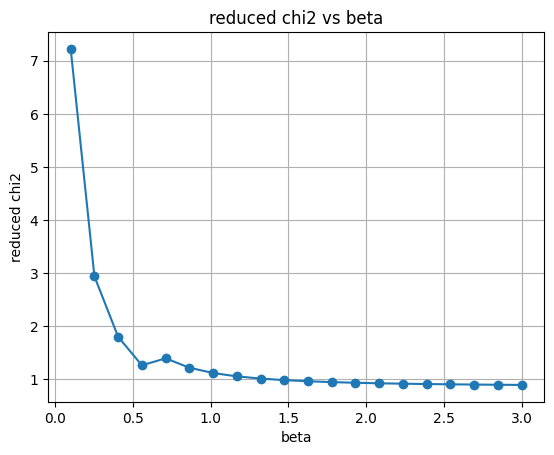

np.float64(1.3210526315789475)

In [139]:
red_chi2s = np.array(red_chi2s)

plt.figure()
plt.plot(np.linspace(0.1, 3.0, 20), red_chi2s, 'o-')
plt.title("reduced chi2 vs beta")
plt.xlabel("beta")
plt.ylabel("reduced chi2")
plt.grid(True)
plt.show()
np.linspace(0.1, 3.0, 20)[np.argmin(abs(red_chi2s - 1))]

In [20]:
import os, json
import numpy as np

# ---- intervals (yours) ----
conc_intervals_edges = np.arange(9e-12, 7e-11 + 1e-13, 4e-12)
amp_intervals_edges = np.arange(0, 5001, 1000)  # 0,1000,2000,3000,4000,5000
frac_intervals_edges = np.arange(0, 1 + 0.01, 0.2)
alpha_intervals_edges = np.arange(1.0, 2.5 + 0.01, 0.1)

# ---- constants / constraints from your generator ----
AMP_MIN, AMP_MAX = 50.0, 5000.0   # sampling range
DELTA = 400.0                     # minimum separation between sorted amps

# ---- helper to compute bin index (unchanged) ----
def bin_index(x, edges):
    idx = np.searchsorted(edges, x, side='right') - 1
    idx = max(0, min(idx, len(edges) - 2))
    return idx

def safe_get(dct, *keys, default=None):
    cur = dct
    for k in keys:
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    return cur

# ---- build effective amplitude intervals per bin ----
amp_bins = [(amp_intervals_edges[i], amp_intervals_edges[i+1]) for i in range(len(amp_intervals_edges)-1)]
eff_bins = []
for (lo, hi) in amp_bins:
    lo_eff = max(lo, AMP_MIN)
    hi_eff = min(hi, AMP_MAX)   # last bin is closed at AMP_MAX in your binning
    if hi_eff <= lo_eff:
        eff_bins.append(None)   # unreachable
    else:
        eff_bins.append((lo_eff, hi_eff))

B = len(eff_bins)

# ---- feasibility checks ----
def feasible_pair(i, j, delta=DELTA):
    Ii = eff_bins[i]; Ij = eff_bins[j]
    if Ii is None or Ij is None: return False
    if j < i: return False
    return (Ij[1] - Ii[0]) >= delta

def feasible_triple(i, j, k, delta=DELTA):
    Ii = eff_bins[i]; Ij = eff_bins[j]; Ik = eff_bins[k]
    if Ii is None or Ij is None or Ik is None: return False
    if not (i <= j <= k): return False
    # need overlap between Ij and [min(Ii)+delta, max(Ik)-delta]
    a_low = Ii[0]
    c_high = Ik[1]
    if (c_high - a_low) < 2*delta:
        return False
    req_lo = a_low + delta
    req_hi = c_high - delta
    # overlap > 0
    return max(Ij[0], req_lo) < min(Ij[1], req_hi)

# ---- enumerate feasible index tuples and build compact mappings ----
pair_list = [(i, j) for i in range(B) for j in range(i, B) if feasible_pair(i, j)]
pair_to_idx = {p: idx for idx, p in enumerate(pair_list)}

triple_list = [(i, j, k) for i in range(B) for j in range(i, B) for k in range(j, B) if feasible_triple(i, j, k)]
triple_to_idx = {t: idx for idx, t in enumerate(triple_list)}

# ---- sizes for fractions and alpha ----
F = len(frac_intervals_edges) - 1
A = len(alpha_intervals_edges) - 1

print(f"# feasible (i<=j) amp-bin pairs:   {len(pair_list)}  out of {B*(B+1)//2}")
print(f"# feasible (i<=j<=k) amp triples:  {len(triple_list)} out of {(B*(B+1)*(B+2))//6}")
print(f"amp bins B={B}, frac bins F={F}, alpha bins A={A}")

# ---- allocate compact phase spaces (use uint32 for counts) ----
phase_power_law = np.zeros((A,), dtype=np.uint32)               # alpha
phase_1s        = np.zeros((B,), dtype=np.uint32)               # AmpS1 bin only
phase_2s_cmp    = np.zeros((len(pair_list), F), dtype=np.uint32)           # (pair_index, Frac1)
phase_3s_cmp    = np.zeros((len(triple_list), F, F), dtype=np.uint32)      # (triple_index, Frac1, Frac2)

# ---- binning helpers for fractions ----
def bin_frac(x):
    return bin_index(x, frac_intervals_edges)

def bin_amp(x):
    return bin_index(x, amp_intervals_edges)

def bin_alpha(x):
    return bin_index(x, alpha_intervals_edges)

# ---- iterate your dataset ----
root = '/content/train/pchdata'
for gtfile in sorted(os.listdir(root)):
    if not gtfile.endswith('.json'):
        continue
    with open(os.path.join(root, gtfile)) as f:
        gt = json.load(f)

    nsp = safe_get(gt, 'SimulationInputs', 'num_species', default=None)
    if nsp is None: 
        continue

    if nsp == 0:
        alpha = safe_get(gt, 'SimulationInputs', 'alpha', default=None)
        if alpha is None: continue
        ai = bin_alpha(alpha)
        phase_power_law[ai] += 1

    elif nsp == 1:
        a1 = safe_get(gt, 'Amplitudes', 'AmpS1', default=None)
        if a1 is None: continue
        i1 = bin_amp(a1)
        phase_1s[i1] += 1

    elif nsp == 2:
        a1 = safe_get(gt, 'Amplitudes', 'AmpS1', default=None)
        a2 = safe_get(gt, 'Amplitudes', 'AmpS2', default=None)
        f1 = safe_get(gt, 'ActualFractions', 'Frac1', default=None)
        if None in (a1, a2, f1): continue
        i1, i2 = sorted([bin_amp(a1), bin_amp(a2)])
        jf = bin_frac(f1)
        p = (i1, i2)
        idx = pair_to_idx.get(p, None)
        if idx is not None:     # only count feasible states
            phase_2s_cmp[idx, jf] += 1

    elif nsp == 3:
        a1 = safe_get(gt, 'Amplitudes', 'AmpS1', default=None)
        a2 = safe_get(gt, 'Amplitudes', 'AmpS2', default=None)
        a3 = safe_get(gt, 'Amplitudes', 'AmpS3', default=None)
        f1 = safe_get(gt, 'ActualFractions', 'Frac1', default=None)
        f2 = safe_get(gt, 'ActualFractions', 'Frac2', default=None)
        if None in (a1, a2, a3, f1, f2): continue
        i1, i2, i3 = sorted([bin_amp(a1), bin_amp(a2), bin_amp(a3)])
        j1 = bin_frac(f1)
        j2 = bin_frac(f2)
        t = (i1, i2, i3)
        idx = triple_to_idx.get(t, None)
        if idx is not None:
            phase_3s_cmp[idx, j1, j2] += 1

# ---- reporting ----
print("Totals (sums should match #files by category):")
print("  power-law:", int(phase_power_law.sum()))
print("  1-species:", int(phase_1s.sum()))
print("  2-species:", int(phase_2s_cmp.sum()))
print("  3-species:", int(phase_3s_cmp.sum()))
print("  TOTAL:", int(phase_power_law.sum() + phase_1s.sum() + phase_2s_cmp.sum() + phase_3s_cmp.sum()))

print("\nOccupancy (nonzeros / capacity) in compact spaces:")
print("  power-law:", np.count_nonzero(phase_power_law), "/", phase_power_law.size)
print("  1-species:", np.count_nonzero(phase_1s), "/", phase_1s.size)
print("  2-species (pairs×F):", np.count_nonzero(phase_2s_cmp), "/", phase_2s_cmp.size)
print("  3-species (triples×F×F):", np.count_nonzero(phase_3s_cmp), "/", phase_3s_cmp.size)


# feasible (i<=j) amp-bin pairs:   15  out of 15
# feasible (i<=j<=k) amp triples:  35 out of 35
amp bins B=5, frac bins F=5, alpha bins A=15
Totals (sums should match #files by category):
  power-law: 3725
  1-species: 3729
  2-species: 3871
  3-species: 3736
  TOTAL: 15061

Occupancy (nonzeros / capacity) in compact spaces:
  power-law: 15 / 15
  1-species: 5 / 5
  2-species (pairs×F): 75 / 75
  3-species (triples×F×F): 324 / 875
